# Explore pyiron-like workflows

Aim: Explore how close the presently available features of the pyiron_workflow class allow us to write pyiron-like workflows

In [1]:
%config IPCompleter.evaluation='unsafe'

import matplotlib.pylab as plt
import numpy as np
from pyiron_workflow.workflow import Workflow

In [2]:
%%time
# from pyiron_atomistics.atomistics.structure.atoms import Atoms

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 5.25 µs


In [3]:
import warnings
warnings.filterwarnings('ignore')

### Create structure and list available potentials

In [4]:
wf = Workflow('Lammps')
wf.register('pyiron_workflow.node_library.atomistic', domain='atomistic')
wf.register('pyiron_workflow.node_library.atomistic_codes', domain='atomistic_codes')

In [5]:
wf = Workflow('Lammps')
wf.structure = wf.create.atomistic.structure.build.bulk('Al', cubic=True)
wf.repeat = wf.create.atomistic.structure.transform.repeat(structure=wf.structure, repeat_scalar=1)

wf.lammps = wf.create.atomistic_codes.Lammps(structure=wf.repeat, label='lammps')
wf.lammps.ListPotentials()[:5]

['1995--Angelo-J-E--Ni-Al-H--LAMMPS--ipr1',
 '1996--Farkas-D--Nb-Ti-Al--LAMMPS--ipr1',
 '1997--Liu-X-Y--Al-Mg--LAMMPS--ipr1',
 '1998--Liu-X-Y--Al-Mg--LAMMPS--ipr1',
 '1999--Liu-X-Y--Al-Cu--LAMMPS--ipr1']

In [6]:
wf = Workflow('Lammps')
wf.structure = wf.create.atomistic.structure.build.bulk('Al', cubic=True)
wf.repeat = wf.create.atomistic.structure.transform.repeat(structure=wf.structure, repeat_scalar=1)

wf.lammps = wf.create.atomistic_codes.Lammps(structure=wf.repeat, label='lammps')
wf.lammps.ListPotentials()[:5]

['1995--Angelo-J-E--Ni-Al-H--LAMMPS--ipr1',
 '1996--Farkas-D--Nb-Ti-Al--LAMMPS--ipr1',
 '1997--Liu-X-Y--Al-Mg--LAMMPS--ipr1',
 '1998--Liu-X-Y--Al-Mg--LAMMPS--ipr1',
 '1999--Liu-X-Y--Al-Cu--LAMMPS--ipr1']

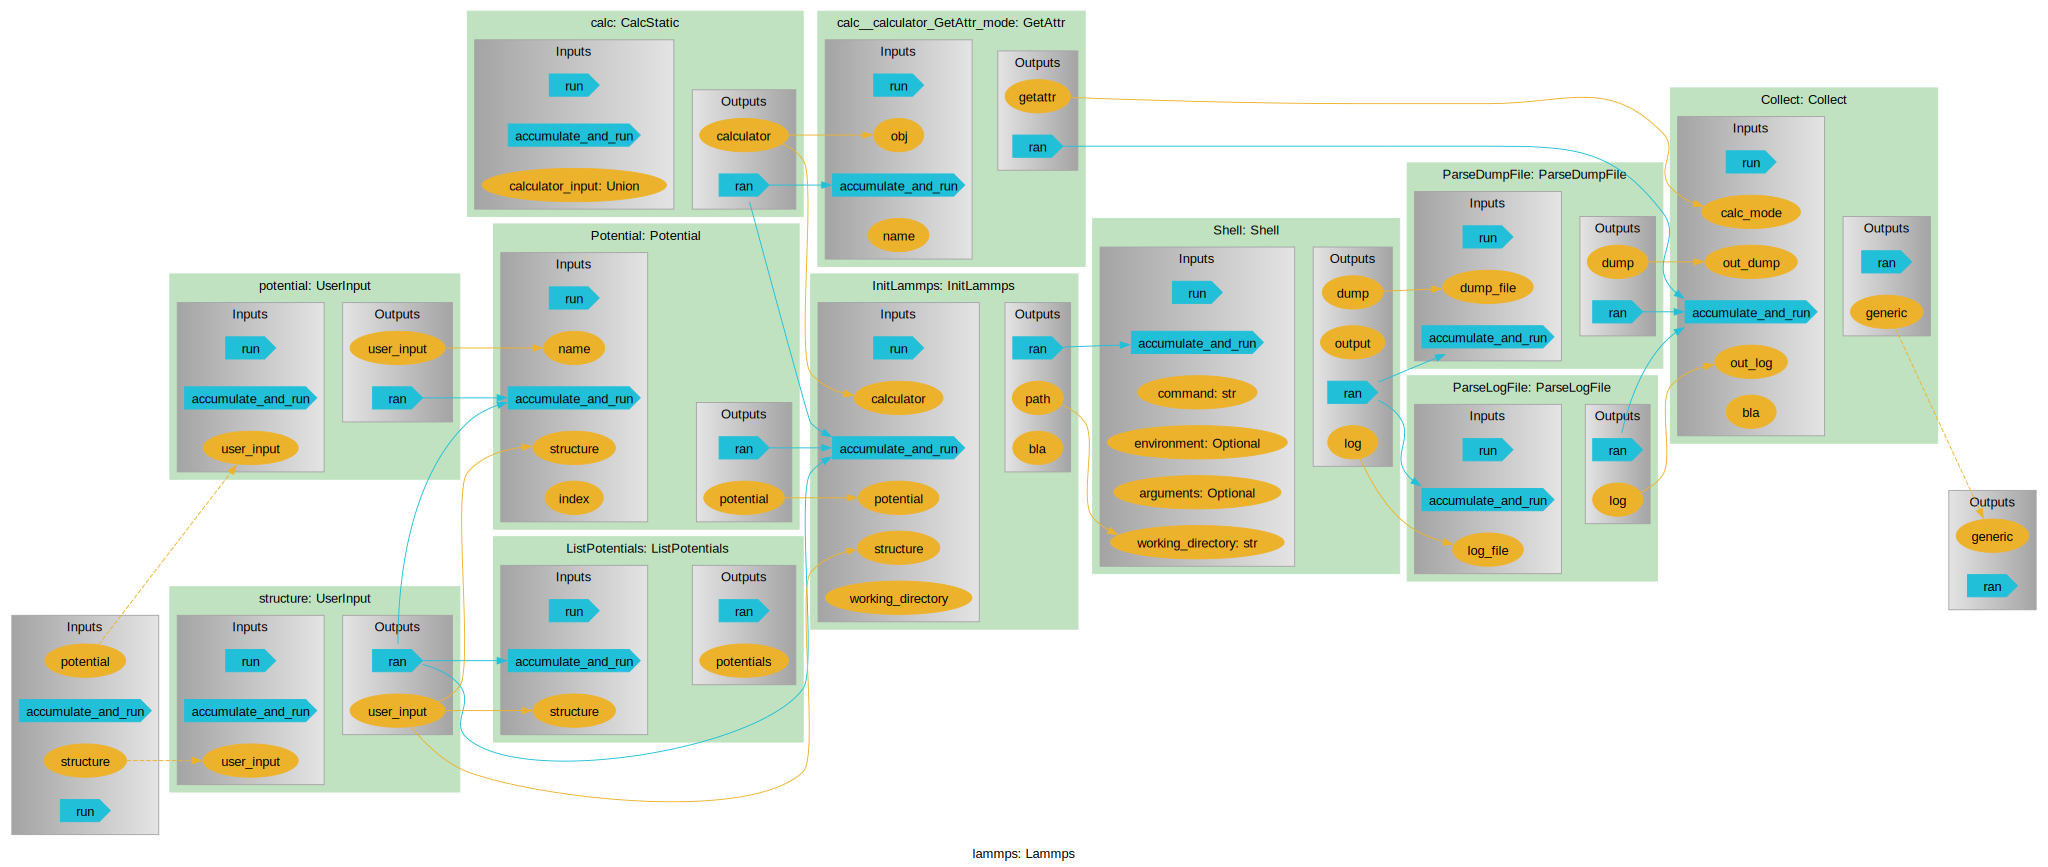

In [7]:
wf.lammps.draw(depth=2)

In [8]:
out = wf.run()
print (f'Potential energy: {wf.lammps.outputs.generic.value.energy_pot}')

Collect:  static 
Potential energy: -13.4399999882896


In [9]:
wf.lammps.Collect

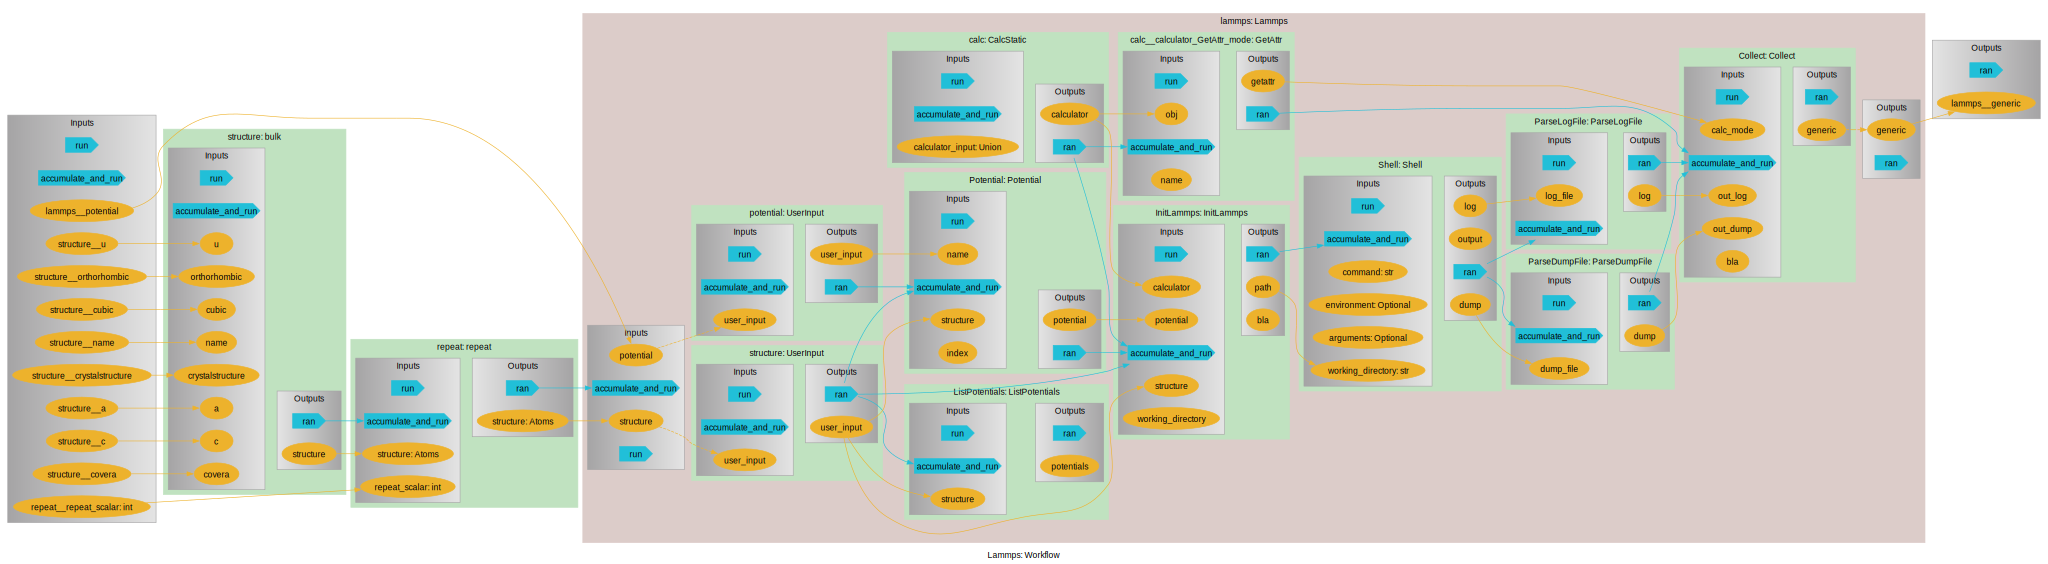

In [10]:
wf.draw(depth=2)

### MD over list of temperatures

T= 300
Collect:  md 
T= 600
Collect:  md 
T= 900
Collect:  md 
CPU times: user 476 ms, sys: 277 ms, total: 753 ms
Wall time: 4.84 s


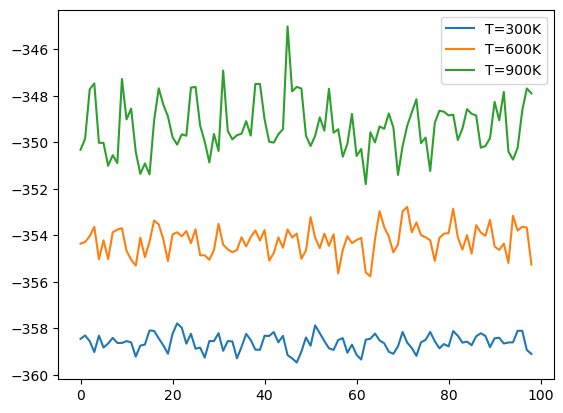

In [11]:
%%time
for T in [300, 600, 900]:
    wf = Workflow('Lammps')
    wf.structure = wf.create.atomistic.structure.build.bulk('Al', cubic=True)
    wf.repeat = wf.create.atomistic.structure.transform.repeat(structure=wf.structure, repeat_scalar=3)
    
    wf.lammps = wf.create.atomistic_codes.Lammps(structure=wf.repeat, label='lammps')
    wf.lammps.calc_select.md(
        calculator_input = {
            "temperature": T, 
            "n_ionic_steps": 10_000
        }
    )
    print ('T=', wf.lammps.calc.inputs.calculator_input.value["temperature"])
    
    wf.run()
    
    plt.plot(wf.lammps.outputs.generic.value.energies_pot[2:], label=f'T={T}K')
plt.legend();    

In [12]:
wf.draw(depth=2);

In [13]:
wf.lammps.draw();

### Murnaghan (E-V) macro

In [14]:
@Workflow.wrap_as.macro_node('energy_pot')
def energy_at_volume(wf, element='Al', cell_size=2, strain=0):
    wf.bulk = wf.create.atomistic.structure.build.cubic_bulk_cell(element=element, cubic=True, cell_size=cell_size)
    wf.apply_strain = wf.create.atomistic.structure.transform.apply_strain(structure=wf.bulk.outputs.structure, strain=strain)
    
    wf.lammps = wf.create.atomistic_codes.Lammps(structure=wf.apply_strain, label='lammps')
    
    return wf.lammps.outputs.generic.energy_pot
    #return wf.bulk

In [15]:
energy_at_volume()()

Collect:  static 


{'energy_pot': -107.519999906317}

In [16]:
wf = Workflow('Lammps')
wf.bulk = wf.create.atomistic.structure.build.cubic_bulk_cell(element='Al', cubic=True)

wf.run()

{'bulk__structure': Al: [0. 0. 0.]
 Al: [0.    2.025 2.025]
 Al: [2.025 0.    2.025]
 Al: [2.025 2.025 0.   ]
 tags: 
     indices: [0 0 0 0]
 pbc: [ True  True  True]
 cell: 
 Cell([4.05, 4.05, 4.05])}

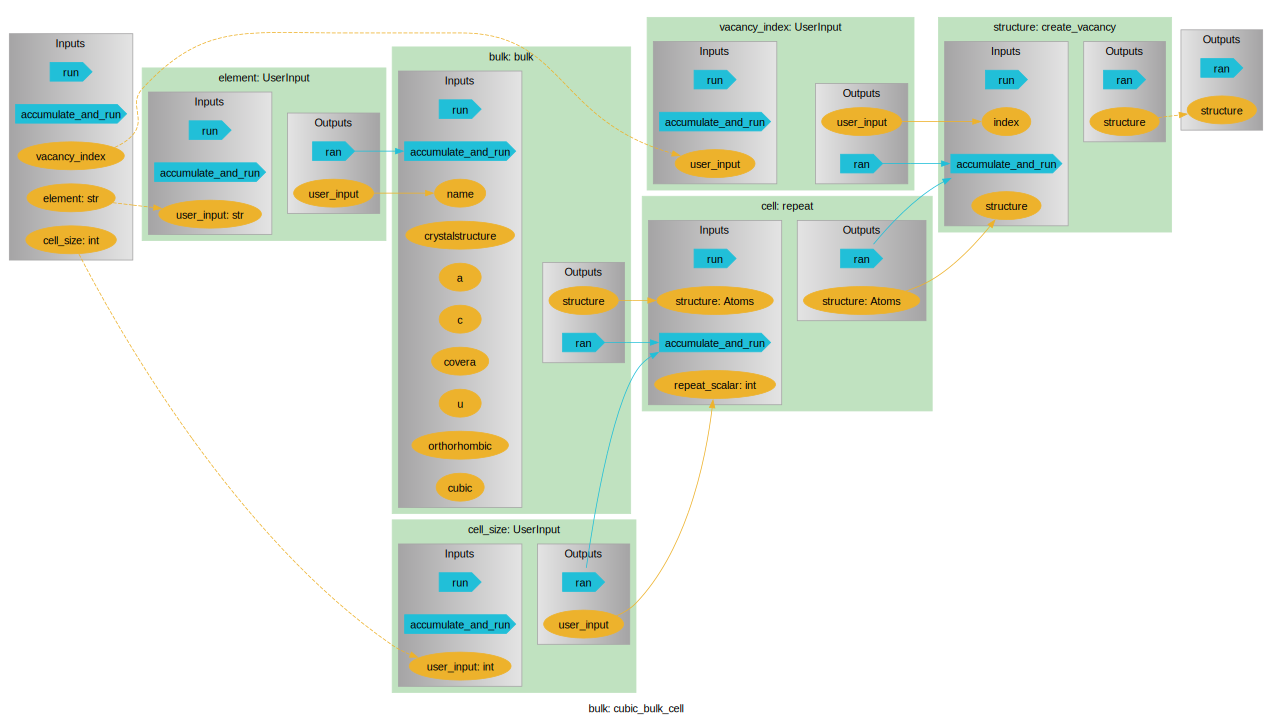

In [17]:
wf.bulk.draw(size=(20,10))

max_workers:  1
Collect:  static 
Collect:  static 
Collect:  static 
Collect:  static 
Collect:  static 
Collect:  static 
Collect:  static 
Collect:  static 
Collect:  static 
Collect:  static 
Collect:  static 


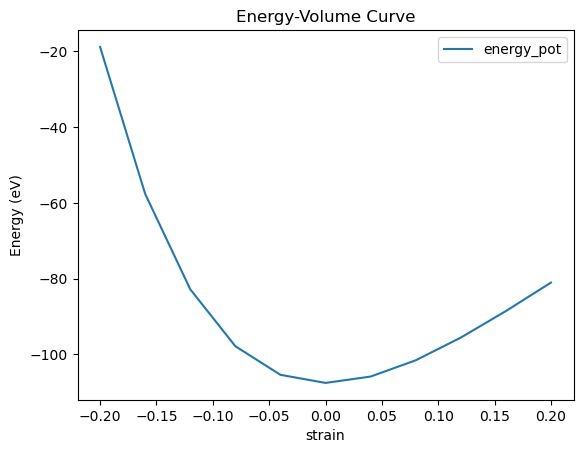

In [18]:
df = energy_at_volume().iter(strain=np.linspace(-0.2, 0.2, 11))
df.plot(x='strain', ylabel='Energy (eV)', title='Energy-Volume Curve');

In [40]:
df

,strain,energy_pot
0,-0.20,-18.803181
1,-0.16,-57.602047
2,-0.12,-82.793493
3,-0.08,-97.826118
4,-0.04,-105.378539
5,0.00,-107.520000
6,0.04,-105.838871
7,0.08,-101.545279
8,0.12,-95.552919
9,0.16,-88.544120


Collect:  static 
Collect:  static 
Collect:  static 
Collect:  static 
Collect:  static 
Collect:  static 
Collect:  static 
Collect:  static 
Collect:  static 
Collect:  static 
Collect:  static 


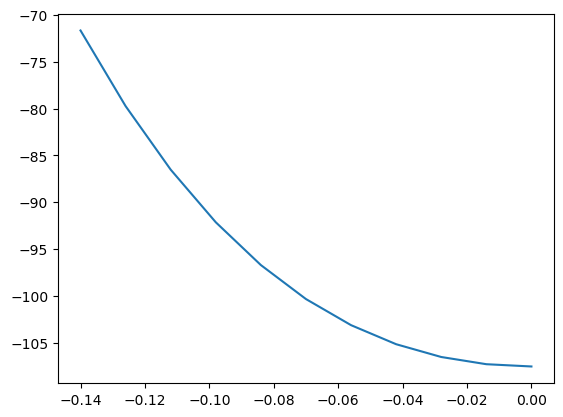

In [19]:
import numpy as np

energy_pot = []
strain_lst = np.linspace(0.86, 1, 11) - 1
for strain in strain_lst:
    wf = energy_at_volume(element='Al', strain=strain)
    out = wf.run()

    energy_pot.append(out['energy_pot'])  

plt.plot(strain_lst, energy_pot);

### Data store

Temporarily deprecated until we merge with the existing storage branch

In [20]:
# from pyiron_workflow.node_library.dev_tools import DataStore, node_to_data_container, extract_value

In [21]:
# ds = DataStore(path='DataStore')
# ds.store(wf, overwrite=True)

In [22]:
# wf_new = ds.load(wf.label)

In [23]:
# wf.lammps

In [24]:
# wf.outputs.energy_pot.value

TODO: Convert data_container to node

In [25]:
# out = wf(element='Fe')

In [26]:
# ds.remove(wf.label)

#### Test pickle

In [27]:
# import  cloudpickle as pickle

In [28]:
# with open('node.pickle', 'wb') as f:
#     pickle.dump(wf, f)

In [29]:
# with open('node.pickle', 'rb') as f:
#     new_node = pickle.load(f)

In [30]:
# new_node.run();

In [31]:
# new_node.outputs.energy_pot.value

In [32]:
# out.energy_pot

In [33]:
# out

## Apply Jan's atomistic class

In [34]:
wf.register('pyiron_workflow.node_library.atomistics', domain='atomistics')

In [35]:
wf = Workflow('Murnaghan')
wf.bulk = wf.create.atomistics.task.Bulk('Al', cubic=True)
wf.lammps = wf.create.atomistics.calculator.Lammps()
wf.lammps_potential = wf.create.atomistics.calculator.LammpsPotential(structure=wf.bulk)
wf.macro = wf.create.atomistics.macro.EnergyVolumeCurve(calculator=wf.lammps)

In [36]:
bulk = wf.bulk.run()
bulk

Atoms(symbols='Al', pbc=True, cell=[[0.0, 2.025, 2.025], [2.025, 0.0, 2.025], [2.025, 2.025, 0.0]])

In [37]:
wf.lammps_potential.inputs

In [38]:
wf.draw();

#### Debug example

In [39]:
@Workflow.wrap_as.single_value_node('string')
def create_string(my_string: str=''):
    return my_string

@Workflow.wrap_as.single_value_node('string')
def plus(my_string_1: str='', my_string_2: str='', my_string_3: str='', my_string_4: str=''):
    return my_string_1 + my_string_2 + my_string_3 + my_string_4

AttributeError: 'Wrappers' object has no attribute 'single_value_node'

In [ ]:
wf = Workflow('test')

wf.string1 = create_string('a')
wf.string2 = create_string('b')
wf.string3 = create_string('c')

wf.sum_1 = plus(wf.string1, wf.string2, wf.string1)
wf.sum_2 = plus(wf.sum_1, wf.string3)
wf.sum_3 = plus(wf.sum_2, wf.string1, wf.string2)

wf.draw()